## Importing segmentations

This notebook shows how to import segmentation data to the Eyened database.

In [1]:
import json
import io
import requests
import numpy as np
from matplotlib import pyplot as plt


In [2]:
api_url = 'http://localhost:18023/api/'

## Segmentations @ eyened-orm

The segmentations in Eyened ORM follow a few rules:

- All segmentations have shape (H,W,D)
- the Height, Width, Depth columns of the Segmentation object must always match the shape of the stored numpy array data
- All segmentations are attached to a single image instance
- segmentations shape and parameteres defines how the annotation is matched to the image volume.

### examples of valid annotation shapes

- 2D on 2D:
    - image: (1024, 1024, 1), annotation (1024, 1024, 1), ScanIndices = NULL -> 2D annotation on a 2D enface image
    - image: (1024, 1024, 1), annotation (256, 256, 1), ScanIndices = NULL  -> 2D annotation on a 2D enface image. ImageProjectionMatrix used to project the annotation onto the image.
    - image: (1, 200, 100), annotation (1, 200, 100), ScanIndices = NULL -> 2D annotation on a single B-scan

- 2D on 3D:
    - image: (200,200,100), annotation (200, 200, 1), ScanIndices = 5 -> 2D annotation on a volume along the depth dimension. ScanIndices=5 indicates the index of the scan. The index will always be relative to the one axis with length = 1.

- 3D on 3D:
    - image: (200,200,100), annotation (200, 200, 100), ScanIndices = NULL -> full volumetric (3D annotation)
    - image: (200,200,100), annotation (200, 200, 100), SparseAxis=Height, ScanIndices = [5,45,76,89,101] -> Sparse 2D segmentations of 5 slices along the height dimension. Sparse segmentations (SparseAxis != NULL) are a special case. They are stored as whole volumes together with a list of indices corresponding to the annotated slices. 
  
- If the shape of the annotation does not match the shape of its image instance (default case), the ImageProjectionMatrix must be provided to map the annotation to image coordinates. This 2D transformation will be applied to the axes with dimension != 1 for non-sparse segmentations and to the axes != SparseAxis for sparse segmentations.

## Working with annotations

- Annotations can be created by providing database columns and numpy arrays satisfying the constraints above.
- After an annotation is created it can only be replaced with an annotation of the same shape. This is intentional to encourage consistency.

## New annotation with metadata

In [3]:
# Create a sample numpy array
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.uint8)[...,None]

# Serialize numpy array to bytes
buffer = io.BytesIO()
np.save(buffer, data)
buffer.seek(0)

metadata = {
    'ImageInstanceID': 246976, # CFI image
    'FeatureID': 43,
    'AnnotationTypeID': 13,
    
    'Width': 3,
    'Height': 3,
    'Depth': 1,
    'ImageProjectionMatrix': [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
}


files = {
    'np_array': ('data.npy', buffer.read(), 'application/octet-stream'),
    'metadata': (None, json.dumps(metadata), 'application/json')
}

# Send POST request with binary data
response = requests.post(
    api_url + f'segmentations',
    files=files
).json()
annotation_id = response["AnnotationID"]

In [4]:
response

{'Width': 3,
 'SeriesID': None,
 'DateInserted': '2025-07-14T22:34:59',
 'ScanIndices': None,
 'ImageInstanceID': 246976,
 'Height': 3,
 'CreatorID': 1,
 'Depth': 1,
 'FeatureID': 43,
 'ImageProjectionMatrix': [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
 'AnnotationTypeID': 13,
 'SparseAxis': None,
 'AnnotationReferenceID': None,
 'PatientID': None,
 'Inactive': False,
 'ZarrArrayIndex': 23,
 'StudyID': None,
 'AnnotationID': 1962416}

## Reading the segmentation data

In [5]:
response = requests.get(
    api_url + f'segmentations/{annotation_id}/data',
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)

In [6]:
np_array.shape

(3, 3, 1)

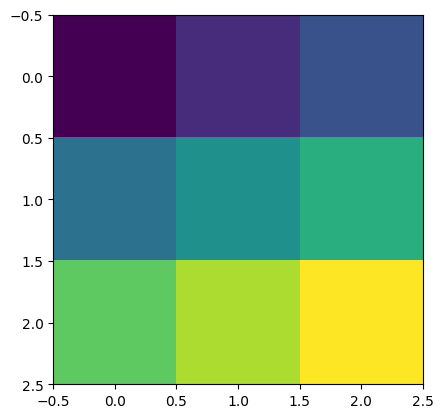

In [7]:
plt.imshow(np_array)

## Replacing segmentation data

In [8]:
# Update segmentation data using PUT request
# Create a modified numpy array (different from the original)
updated_data = np.array([[9, 8, 7], [6, 5, 4], [3, 2, 1]], dtype=np.uint8)[...,None]

# Serialize numpy array to bytes
buffer = io.BytesIO()
np.save(buffer, updated_data)
buffer.seek(0)

# Send PUT request with raw binary data
response = requests.put(
    api_url + f'segmentations/{annotation_id}/data',
    data=buffer.read(),
    headers={'Content-Type': 'application/octet-stream'}
)

In [9]:
response = requests.get(
    api_url + f'segmentations/{annotation_id}/data'
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)

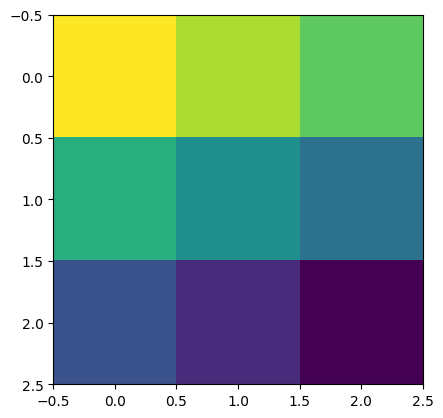

In [10]:
plt.imshow(np_array)

## replacing with different shape (error)

In [11]:
# Update segmentation data using PUT request
# Create a modified numpy array (different from the original)
updated_data = np.array([[9, 8, 7], [6, 5, 4], [3, 2, 1], [0,0,0]], dtype=np.uint8)[...,None]

# Serialize numpy array to bytes
buffer = io.BytesIO()
np.save(buffer, updated_data)
buffer.seek(0)

# Send PUT request with raw binary data
response = requests.put(
    api_url + f'segmentations/{annotation_id}/data',
    data=buffer.read(),
    headers={'Content-Type': 'application/octet-stream'}
).json()

In [12]:
response

{'detail': 'Expected spatial dimensions (3, 3, 1), got (4, 3, 1)'}

## OCT Volume Annotation

In [13]:
## New empty annotation
metadata = {
    'ImageInstanceID': 246977, # CFI image
    'FeatureID': 43,
    'AnnotationTypeID': 13,
}

files = {
    'metadata': (None, json.dumps(metadata), 'application/json')
}

# Send POST request with binary data
response = requests.post(
    api_url + f'segmentations',
    files=files
).json()
annotation_id = response['AnnotationID']

## write single slice

In [14]:
new_slice = np.random.randint(0, 255, (response['Height'],response['Width']), dtype=np.uint8)
new_slice[300:350,...] = 255

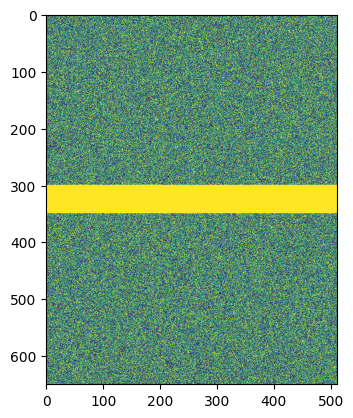

In [15]:
plt.imshow(new_slice)

In [16]:
buffer = io.BytesIO()
np.save(buffer, new_slice)
buffer.seek(0)

# Send PUT request with raw binary data
response = requests.put(
    api_url + f'segmentations/{annotation_id}/data',
    data=buffer.read(),
    headers={'Content-Type': 'application/octet-stream'},
    params={'axis': 2, 'scan_nr': 34}
)
assert response.status_code == 204

# read single slices

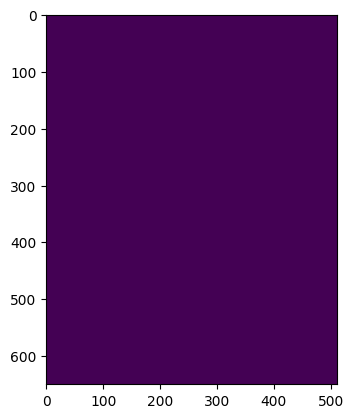

In [17]:
response = requests.get(
    api_url + f'segmentations/{annotation_id}/data',
    params={'axis': 2, 'scan_nr': 33}
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)
plt.imshow(np_array)

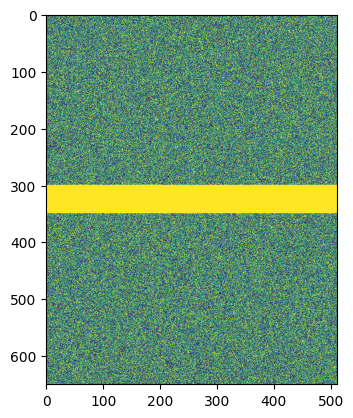

In [18]:
response = requests.get(
    api_url + f'segmentations/{annotation_id}/data',
    params={'axis': 2, 'scan_nr': 34}
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)
plt.imshow(np_array)

## Sparse annotations

In [19]:
## New empty annotation
metadata = {
    'ImageInstanceID': 246977, # CFI image
    'FeatureID': 43,
    'AnnotationTypeID': 13,
    'SparseAxis': 2,
    'ScanIndices': []
}

files = {
    'metadata': (None, json.dumps(metadata), 'application/json')
}

# Send POST request with binary data
response = requests.post(
    api_url + f'segmentations',
    files=files
).json()
annotation_id = response['AnnotationID']

In [20]:
response

{'Width': 512,
 'SeriesID': None,
 'DateInserted': '2025-07-14T22:35:01',
 'ScanIndices': [],
 'ImageInstanceID': 246977,
 'Height': 650,
 'CreatorID': 1,
 'Depth': 128,
 'FeatureID': 43,
 'ImageProjectionMatrix': None,
 'AnnotationTypeID': 13,
 'SparseAxis': 2,
 'AnnotationReferenceID': None,
 'PatientID': None,
 'Inactive': False,
 'ZarrArrayIndex': 22,
 'StudyID': None,
 'AnnotationID': 1962418}

## write some indices of sparse array

In [21]:
new_slice = np.full((response['Height'],response['Width']), 255, dtype=np.uint8)
buffer = io.BytesIO()
np.save(buffer, new_slice)


for i in [10,20,30,40,50]:
    # Send PUT request with raw binary data
    buffer.seek(0)
    response = requests.put(
        api_url + f'segmentations/{annotation_id}/data',
        data=buffer.read(),
        headers={'Content-Type': 'application/octet-stream'},
        params={'axis': 2, 'scan_nr': i}
    )
    assert response.status_code == 204

## Read the annotation and volume

In [24]:
annot = requests.get(
    api_url + f'segmentations/{annotation_id}',
).json()
response = requests.get(
    api_url + f'segmentations/{annotation_id}/data',
)
data_buffer = io.BytesIO(response.content)
np_array = np.load(data_buffer)

In [25]:
np_array.shape

(650, 512, 128)

In [27]:
annot['ScanIndices']

[10, 20, 30, 40, 50]

In [32]:
np_array[0,0,annot['ScanIndices'][0]-1], np_array[0,0,annot['ScanIndices'][0]], np_array[0,0,annot['ScanIndices'][0]+1]

(np.uint8(0), np.uint8(255), np.uint8(0))

## Overview of stored annotations

- Zarr arrays are stored in groups. Each group maps to one SegmentationType
- Within each group, arrays are identified by `<dtype>_<height>_<width>_<depth>` of the segmentation.

In [ ]:
!eorm zarr-tree --env dev

Zarr store: /mnt/ssd2/annotations_store.zarr

Group: 13
------------------------------
  Array: float32_3_3_1.zarr
    Shape: (1, 3, 3, 1)
    Dtype: float32
    Chunks: (1, 3, 3, 1)
  Array: uint8_1536_2048_1.zarr
    Shape: (1, 1536, 2048, 1)
    Dtype: uint8
    Chunks: (1, 1536, 2048, 1)
  Array: uint8_3_3_1.zarr
    Shape: (15, 3, 3, 1)
    Dtype: uint8
    Chunks: (1, 3, 3, 1)
  Array: uint8_4_3_1.zarr
    Shape: (7, 4, 3, 1)
    Dtype: uint8
    Chunks: (1, 4, 3, 1)
  Array: uint8_5_3_1.zarr
    Shape: (1, 5, 3, 1)
    Dtype: uint8
    Chunks: (1, 5, 3, 1)
  Array: uint8_650_512_128.zarr
    Shape: (5, 650, 512, 128)
    Dtype: uint8
    Chunks: (1, 650, 512, 128)
